In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import numpy as np
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):

      X, Y = [], []
      for w in words:
            context = [0] * block_size
            for ch in w + '.':
                  ix = stoi[ch]
                  X.append(context)
                  Y.append(ix)
                  context = context[1:] + [ix] # crop and append
      
      X = torch.tensor(X)
      Y = torch.tensor(Y)
      print(X.shape, Y.shape)
      return X,Y


In [5]:
import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])     #80%  
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:])     #10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [17]:
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),generator=g)

# original
# W1 = torch.randn((n_embed*block_size, n_hidden),generator=g)
# b1 = torch.randn(n_hidden, generator=g)
# W2 = torch.randn((n_hidden, vocab_size),generator=g)
# b2 = torch.randn(vocab_size, generator=g)

#fixed softmax confidently wrong ( at initial step, by multiplying 0.01,etc ) 
# W1 = torch.randn((n_embed*block_size, n_hidden),generator=g) * 0.1
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01
# b2 = torch.randn(vocab_size, generator=g) * 0

# kaiming initialisation
gain = 5/3 # for tanh
fan_in = n_embed * block_size
W1 = torch.randn((n_embed * block_size, n_hidden),generator=g) * (gain / (fan_in)**5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01  # no need for this bias as normalisation layer will cancel this off, we already have bnbias for normalisation layer
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


# BatchNorm parameters
bngain = torch.ones((1, n_hidden))  # affine parameters
bnbias = torch.zeros((1, n_hidden)) # affine parameters
# buffers
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias] #, b1]

print(sum(p.nelement() for p in parameters)) #number of parameters in total

for p in parameters:
      p.requires_grad = True

12097


In [18]:
# optimisation

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
      # minibatch construct
      ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
      Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
      
      # forward pass
      emb = C[Xb] # embed the characters into vectors
      embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
      # Linear layer
      hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
      
      # Batchnorm layer
      bnmeani = hpreact.mean(0, keepdim=True)
      bnstdi = hpreact.std(0, keepdim=True)
      hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
      
      # track_running_stats
      with torch.no_grad(): # we'll use these to calibrate at the end of training
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # momentum = 0.001
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # momentum = 0.001
      
      # Non-linearity
      h = torch.tanh(hpreact) # hidden layer
      logits = h @ W2 + b2 # output layer
      loss = F.cross_entropy(logits, Yb) # loss function
      
      # backward pass
      for p in parameters:
            p.grad = None
      loss.backward()
      
      #update 
      lr = 0.1 if i<100000 else 0.01
      for p in parameters:
            p.data += -lr*p.grad
      
      #track stats
      if i%10000 == 0 :
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
      lossi.append(loss.log10().item())
      
      # break

      0/ 200000: 3.3239
  10000/ 200000: 2.1701
  20000/ 200000: 2.7488
  30000/ 200000: 2.0807
  40000/ 200000: 2.4526
  50000/ 200000: 2.0007
  60000/ 200000: 2.3154
  70000/ 200000: 2.2874
  80000/ 200000: 2.5516
  90000/ 200000: 2.2730
 100000/ 200000: 2.3953
 110000/ 200000: 2.4291
 120000/ 200000: 1.7518
 130000/ 200000: 2.0682
 140000/ 200000: 2.4206
 150000/ 200000: 2.2654
 160000/ 200000: 2.1586
 170000/ 200000: 2.4548
 180000/ 200000: 2.2698
 190000/ 200000: 2.3071


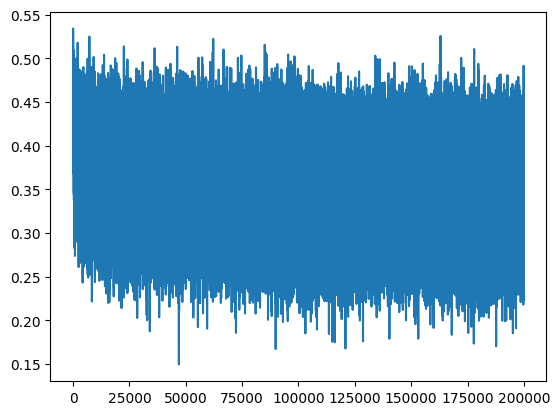

In [8]:
plt.plot(lossi)

In [12]:
# we did track_running_stats above to avoid doing this step

# with torch.no_grad():
#       emb = C[Xtr]
#       embcat = emb.view(emb.shape[0], -1)
#       hpreact = embcat @ W1  #+ b1
      
#       bnmean = hpreact.mean(0, keepdim=True)
#       bnstd = hpreact.std(0, keepdim=True)

In [20]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
      x,y = {
            'train': (Xtr, Ytr),
            'val'  : (Xdev, Ydev),
            'test' : (Xte, Yte),
      }[split]
      
      emb = C[x] # (N, block_size, n_embed)
      embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embed)
      hpreact = embcat @ W1 #+ b1
      
      # bnmeani = hpreact.mean(0, keepdim=True)
      # bnstdi = hpreact.std(0, keepdim=True)
      hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
      
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      loss = F.cross_entropy(logits, y)
      print(split, loss.item())
      
split_loss('train')
split_loss('val')
      

train 2.19775390625
val 2.2099015712738037


In [10]:
#     LOSS LOG

# original:
# train 2.120027542114258
# val 2.162297248840332

# fixed softmax confidently wrong (w2,b2), fixed tanh layer too saturated at init (w1,b2)
# train 2.061760187149048
# val 2.109035015106201

# kaiming initialisation
# train 2.1046199798583984
# val 2.137979507446289

# batch normalisation layer added
# train 2.2044453620910645
# val 2.2142317295074463




In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
          # forward pass the neural net
          emb = C[torch.tensor([context])] # (1,block_size,d)
          h = torch.tanh(emb.view(1, -1) @ W1 + b1)
          logits = h @ W2 + b2
          probs = F.softmax(logits, dim=1)
          
          # sample from the distribution
          ix = torch.multinomial(probs, num_samples=1, generator=g).item()
          
          # shift the context window and track the samples
          context = context[1:] + [ix]
          out.append(ix)
          
          if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

nin.
ammyanhanthn.
durdalahhnmessengrlezh.
dleenhelinnhhnmontrezanthn.
anahlenghhmzohelin.
shahmrihh.
maejt.
nlirnalleh.
nlcknos.
bdighdreshahanzela.
rianhashaldethamlakslahhnnanhahlahhnmil.
ryshnviah.
nlthn.
brnnl.
dlohhh.
prin.
dlethawz.
hurmonthn.
qiignnvonlwalleh.
dlvashahmrih.


In [21]:
### RESTRUCTURING ABOVE CODE AS SUMMARY

In [6]:
from typing import Any


class Linear:
      
      def __init__(self, fan_in, fan_out, bias = True):
            self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
            self.bias = torch.zeros(fan_out) if bias else None
      
      def __call__(self, x):
            self.out = x @ self.weight
            if self.bias is not None:
                  self.out += self.bias
            return self.out
      
      def parameters(self):
            return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
      
      def __init__(self, dim, eps= 1e-5, momentum= 0.1):
            self.eps = eps
            self.momentum = momentum
            self.training = True
            # parameters (trained with backprop)
            self.gamma = torch.ones(dim)
            self.beta = torch.zeros(dim)
            # buffers (trained with a running 'momentum update')
            self.running_mean = torch.zeros(dim)
            self.running_var = torch.ones(dim)
      
      def __call__(self, x):
            #calculate the forward pass
            if self.training:
                  xmean = x.mean(0, keepdim=True) #batch mean
                  xvar = x.var(0, keepdim=True) #batch variance
            else:
                  xmean = self.running_mean
                  xvar = self.running_var
            xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
            self.out = self.gamma * xhat + self.beta
            # update the buffers
            if self.training:
                  with torch.no_grad():
                        self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum*xmean
                        self.running_var = (1 - self.momentum)*self.running_var + self.momentum*xvar
            
            return self.out
      
      def parameters(self):
            return [self.gamma, self.beta]

class Tanh:
      def __call__(self, x):
            self.out = torch.tanh(x)
            return self.out

      def parameters(self):
            return []
                            
                        

In [16]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [17]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
      
      ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
      Xb, Yb = Xtr[ix], Ytr[ix]
      
      emb = C[Xb]
      x = emb.view(emb.shape[0], -1)
      for layer in layers:
            x = layer(x)
      loss = F.cross_entropy(x,Yb)
      
      for layer in layers:
            layer.out.retain_grad()
      for p in parameters:
            p.grad = None
      loss.backward()
      
      lr = 0.1 if i < 100000 else 0.01
      for p in parameters:
            p.data += -lr * p.grad
      
      if i%10000==0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
      lossi.append(loss.log10().item())
      with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
      
      break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.69%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.78%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.72%


Text(0.5, 1.0, 'activation distribution')

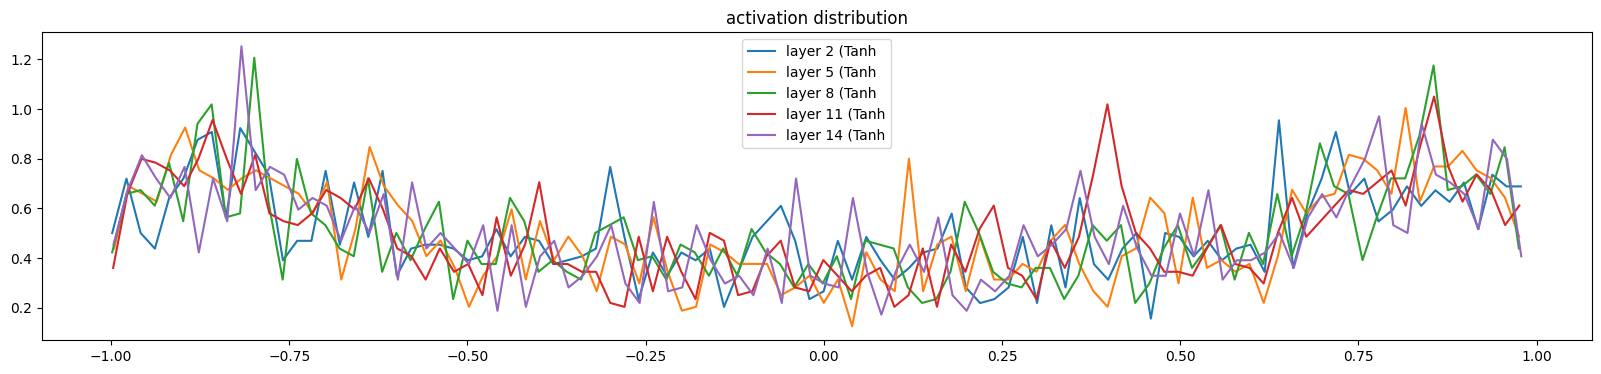

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 8.981794e-04
layer 5 (      Tanh): mean -0.000000, std 7.436763e-04
layer 8 (      Tanh): mean +0.000000, std 6.661872e-04
layer 11 (      Tanh): mean +0.000000, std 5.511573e-04
layer 14 (      Tanh): mean +0.000000, std 4.804440e-04


Text(0.5, 1.0, 'gradient distribution')

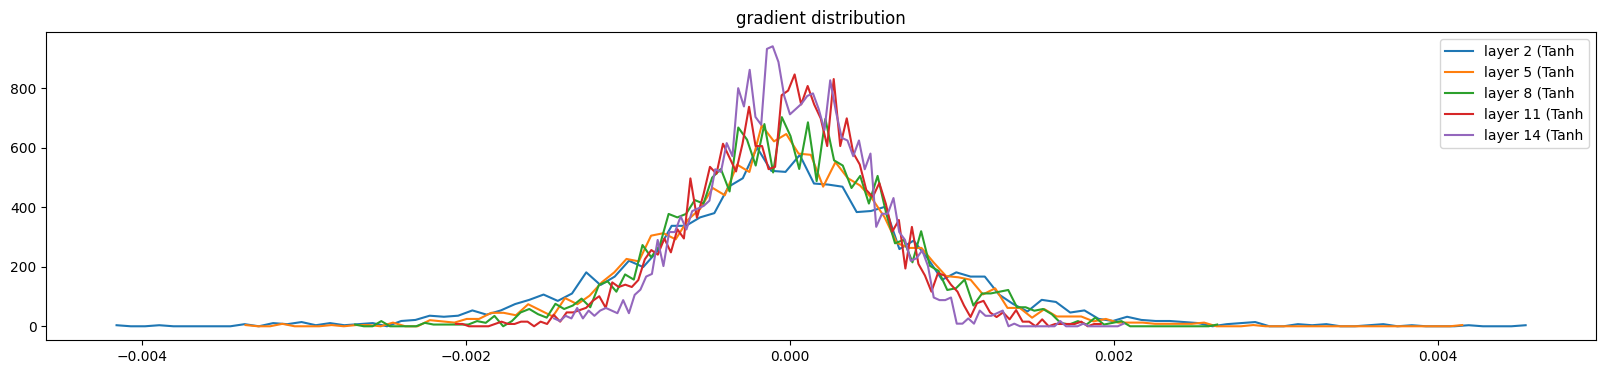

In [19]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.623040e-03 | grad:data ratio 1.621866e-03
weight  (30, 100) | mean -0.000047 | std 1.756820e-03 | grad:data ratio 5.633299e-03
weight (100, 100) | mean +0.000012 | std 1.654092e-03 | grad:data ratio 9.957178e-03
weight (100, 100) | mean -0.000017 | std 1.484452e-03 | grad:data ratio 8.842122e-03
weight (100, 100) | mean -0.000013 | std 1.328060e-03 | grad:data ratio 7.943821e-03
weight (100, 100) | mean -0.000011 | std 1.150042e-03 | grad:data ratio 6.872333e-03
weight  (100, 27) | mean +0.000003 | std 1.998616e-03 | grad:data ratio 1.212869e-02


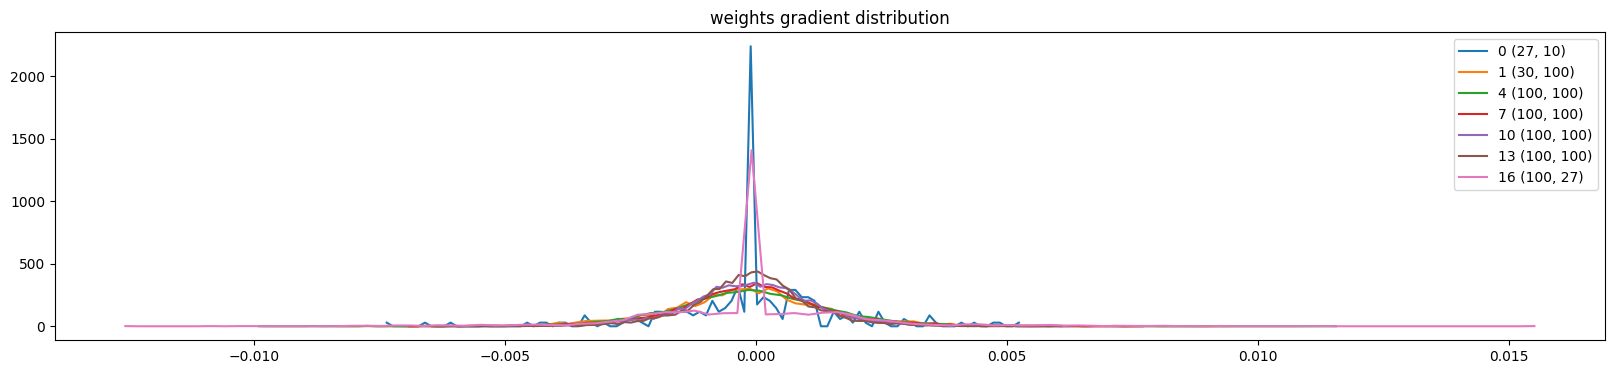

In [20]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

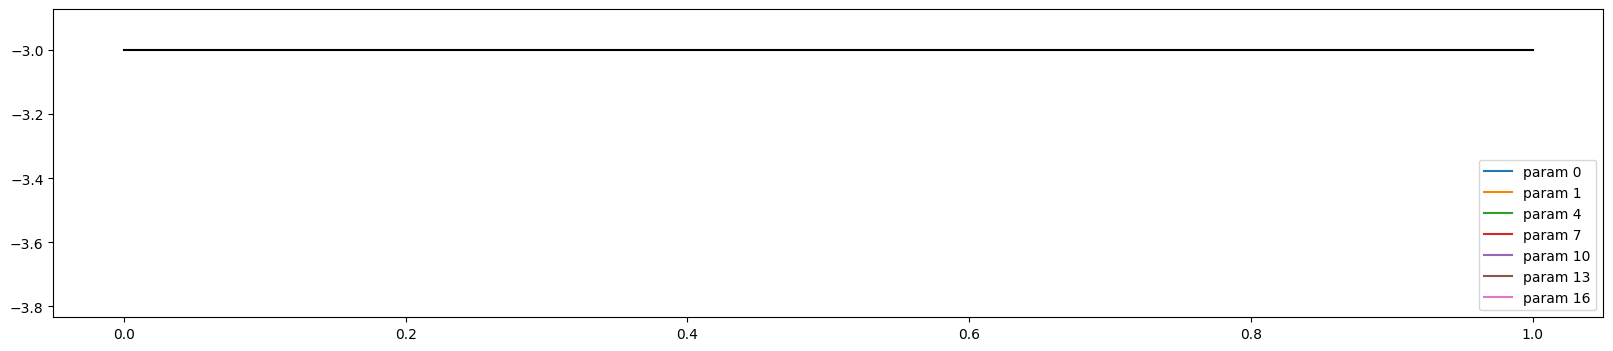

In [21]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);